<html>
    <div style="background-color: lightskyblue; padding: 30px; color: black; text-align: center;">
    <h1>CAB420 - Assignment 2</h1>
    <h2>Building a DCNN Model to Classify Animals and Endangered Status</h2>
    </div>
</html>

Loading in the main modules for the project

In [356]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

Utility Functions

In [335]:
def load_images_from_folders(root_dir):
    # Root directory is 256_ObjectCategories
    
    seen_paths = []
    unseen_paths = []
    # This is the main animals directory
    directories = os.listdir(root_dir)
    directories.sort()

    # This will have the animal directories
    for dirpath in directories:
        if dirpath != '.DS_Store':
            os.chdir(os.path.join(root_dir, dirpath))
            
            seen_unseen_dir = os.listdir(os.getcwd())
            seen_unseen_dir.sort()      
            seen_unseen_dir.pop(0)

            seen_image_count = 0
            unseen_image_count = 0
            # This is the seen and unseen directories
            for folder in seen_unseen_dir:
                # Go into the seen/unseen directory
                os.chdir(os.path.join(root_dir, dirpath, folder))

                # Grab the images in the seen/unseen directory
                images_in_dir = os.listdir(os.getcwd())
                images_in_dir.sort()

                # Append each of the images to the image_paths list
                for image in images_in_dir:
                    if folder == 'seen_images':
                        seen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        seen_image_count += 1
                        
                    elif folder == 'unseen_images':
                        unseen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        unseen_image_count += 1
                    else:
                        print(f"Unknown folder: {folder}")
                        continue

                    # Get out of the seen/unseen directory onto the animals directory
                    os.chdir('..')
                os.chdir('..')
            
            os.chdir('..')
    return seen_paths, unseen_paths

def read_images(image_paths):
    images = []
    for path in image_paths:
        try:
            img = np.array(Image.open(path)) # or img = cv2.imread(path)
            images.append(img)
        except Exception as e:
             print(f"Error loading image: {path} - {e}")
    
    return images

In [336]:
image_root = '/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories'
seen_paths, unseen_paths = load_images_from_folders(image_root)

for path in seen_paths:
    if '.DS_Store' in path:
        print('Mac Really needs to stop this')
        
        seen_paths.remove(path)

seen_images = read_images(seen_paths)
unseen_images = read_images(unseen_paths)


Mac Really needs to stop this
Mac Really needs to stop this


Downloading the datasets

In [337]:
labelled_data = pd.read_csv("/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/labelled_data.csv")
unlabelled_data = pd.read_csv("/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/unlabelled_data.csv")

In [338]:
seen_paths = sorted(seen_paths)
unseen_paths = sorted(unseen_paths)

In [339]:
labelled_data.sort_values(by = 'filename_id', inplace = True)
unlabelled_data.sort_values(by = 'filename_id', inplace = True)

In [340]:
labelled_data

,filename_id,species,endangered
0,007_0001,0,0.2
1,007_0002,0,0.6
2,007_0003,0,0.4
3,007_0004,0,0.0
4,007_0005,0,0.0
...,...,...,...
2461,256_0050,43,0.0
2462,256_0051,43,0.0
2463,256_0052,43,0.0
2464,256_0053,43,0.0


In [341]:
len(seen_images)

2466

These images aren't in a standardised format. Going to implement a resize to keep them in the same format

In [342]:
seen_np_images = []
unseen_np_images = []

for i in range(len(seen_images)):
    image_np = np.array(seen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    seen_np_images.append(image_np) 

for i in range(len(unseen_images)):
    image_np = np.array(unseen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    unseen_np_images.append(image_np)

seen_np_images = np.array(seen_np_images)
unseen_np_images = np.array(unseen_np_images)


Organising the train/test split

In [343]:
len(labelled_data)

2466

In [344]:
len(seen_paths)

2466

In [345]:
sorted_list = sorted(labelled_data['filename_id'].to_list())

In [346]:
for i in range(len(sorted_list)):
    print({sorted_list[i] : sorted_list[i][-12:]})

{'007_0001': '007_0001'}
{'007_0002': '007_0002'}
{'007_0003': '007_0003'}
{'007_0004': '007_0004'}
{'007_0005': '007_0005'}
{'007_0006': '007_0006'}
{'007_0007': '007_0007'}
{'007_0008': '007_0008'}
{'007_0009': '007_0009'}
{'007_0010': '007_0010'}
{'007_0011': '007_0011'}
{'007_0012': '007_0012'}
{'007_0013': '007_0013'}
{'007_0014': '007_0014'}
{'007_0015': '007_0015'}
{'007_0016': '007_0016'}
{'007_0017': '007_0017'}
{'007_0018': '007_0018'}
{'007_0019': '007_0019'}
{'007_0020': '007_0020'}
{'007_0021': '007_0021'}
{'007_0022': '007_0022'}
{'007_0023': '007_0023'}
{'007_0024': '007_0024'}
{'007_0025': '007_0025'}
{'007_0026': '007_0026'}
{'007_0027': '007_0027'}
{'007_0028': '007_0028'}
{'007_0029': '007_0029'}
{'007_0030': '007_0030'}
{'007_0031': '007_0031'}
{'007_0032': '007_0032'}
{'007_0033': '007_0033'}
{'007_0034': '007_0034'}
{'007_0035': '007_0035'}
{'007_0036': '007_0036'}
{'007_0037': '007_0037'}
{'007_0038': '007_0038'}
{'007_0039': '007_0039'}
{'007_0040': '007_0040'}


In [347]:
seen_shapes = [img.shape for img in seen_images]
unseen_shapes = [img.shape for img in unseen_images]

print("Unique shapes in seen_images:", set(seen_shapes))
print("Unique shapes in unseen_images:", set(unseen_shapes))

# 2. Check for count mismatches
print("Number of seen images:", len(seen_images))
print("Number of seen labels:", len(labelled_data))
print("Number of unseen images:", len(unseen_images))
print("Number of unlabelled entries:", len(unlabelled_data))

# 3. Check for failed loads (None or wrong dtype)
failed_seen = [i for i, img in enumerate(seen_images) if img is None or not isinstance(img, np.ndarray)]
failed_unseen = [i for i, img in enumerate(unseen_images) if img is None or not isinstance(img, np.ndarray)]
print("Failed seen image indices:", failed_seen)
print("Failed unseen image indices:", failed_unseen)

Unique shapes in seen_images: {(254, 277, 3), (390, 500, 3), (388, 350, 3), (195, 298, 3), (756, 500, 3), (221, 322, 3), (490, 343, 3), (757, 1000, 3), (551, 367, 3), (198, 144, 3), (456, 608, 3), (487, 464, 3), (329, 450, 3), (225, 255, 3), (191, 283, 3), (450, 576, 3), (125, 180, 3), (413, 650, 3), (210, 280, 3), (105, 150, 3), (265, 402, 3), (768, 1024, 3), (397, 450, 3), (372, 630, 3), (319, 350, 3), (500, 667, 3), (271, 280, 3), (300, 170, 3), (339, 300, 3), (346, 461, 3), (432, 648, 3), (199, 291, 3), (308, 410, 3), (700, 560, 3), (462, 308, 3), (500, 400, 3), (217, 250, 3), (256, 380, 3), (234, 280, 3), (261, 229, 3), (200, 149, 3), (200, 283, 3), (172, 210, 3), (278, 384, 3), (345, 500, 3), (284, 420, 3), (180, 141, 3), (350, 340, 3), (172, 161, 3), (227, 283, 3), (300, 276, 3), (771, 480, 3), (143, 216, 3), (411, 608, 3), (280, 380, 3), (185, 250, 3), (533, 450, 3), (450, 317, 3), (519, 428, 3), (500, 332, 3), (458, 562), (270, 300, 3), (286, 205, 3), (225, 288, 3), (246, 350,

In [348]:
# Labelled data
seen_train_X, seen_test_Y, species_labelled_train_Y, species_labelled_test_Y = train_test_split(seen_np_images, labelled_data['species'], test_size=0.2, random_state=42)
species_labelled_train_Y = species_labelled_train_Y.reset_index(drop=True)

# Unlabelled data
unseen_train_X, unseen_test_X, unlabelled_train_Y, unlabelled_test_Y = train_test_split(unseen_np_images, unlabelled_data['filename_id'], test_size=0.2, random_state=42)
unlabelled_train_Y = unlabelled_train_Y.reset_index(drop=True)

In [349]:
len(unlabelled_data)

2463

In [350]:
species_labelled_train_Y = to_categorical(species_labelled_train_Y)
species_labelled_test_Y = to_categorical(species_labelled_test_Y)

unlabelled_train_Y = to_categorical(unlabelled_train_Y)
unlabelled_test_Y = to_categorical(unlabelled_test_Y)

Visualising the images found

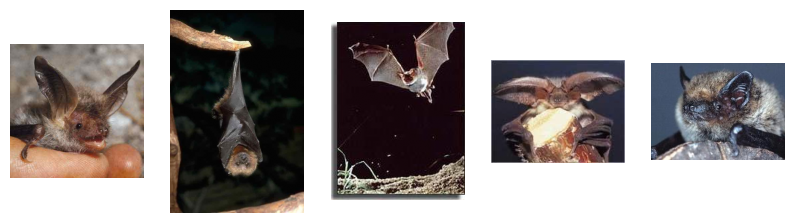

In [351]:
fig = plt.figure(figsize=(10, 10))

image_range = seen_images[0:5]

for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(1, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    except:
        break
plt.show()

### Time to Build the Network

In [369]:
input = keras.Input(shape=(256, 256, 3), name = 'image')

conv2d_layer_one = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input)
batch_norm_layer_one = layers.BatchNormalization()(conv2d_layer_one)
activation_layer_one = layers.Activation('relu')(conv2d_layer_one)
conv2d_layer_two = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(activation_layer_one)
batch_norm_layer_two = layers.BatchNormalization()(conv2d_layer_two)


conv2d_layer_three = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batch_norm_layer_two)
activation_layer_two = layers.Activation('relu')(batch_norm_layer_two)
conv2d_layer_four = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(activation_layer_two)
batch_norm_layer_three = layers.BatchNormalization()(conv2d_layer_four)

flatten_layer = layers.Flatten()(batch_norm_layer_three)

dense_layer_one = layers.Dense(512, activation='relu')(flatten_layer)
output = layers.Dense(44, activation='softmax')(dense_layer_one)

model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2097152)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │ 1,073,742,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 44)             │        22,572 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073,772,508 (4.00 GB)

 Trainable params: 1,073,772,412 (4.00 GB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(seen_train_X, species_labelled_train_Y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


In [364]:
def eval_model(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, Precision Score: %f' % precision_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, Precision Score: %f' % precision_score(gt_idx, indexes, average='weighted'))

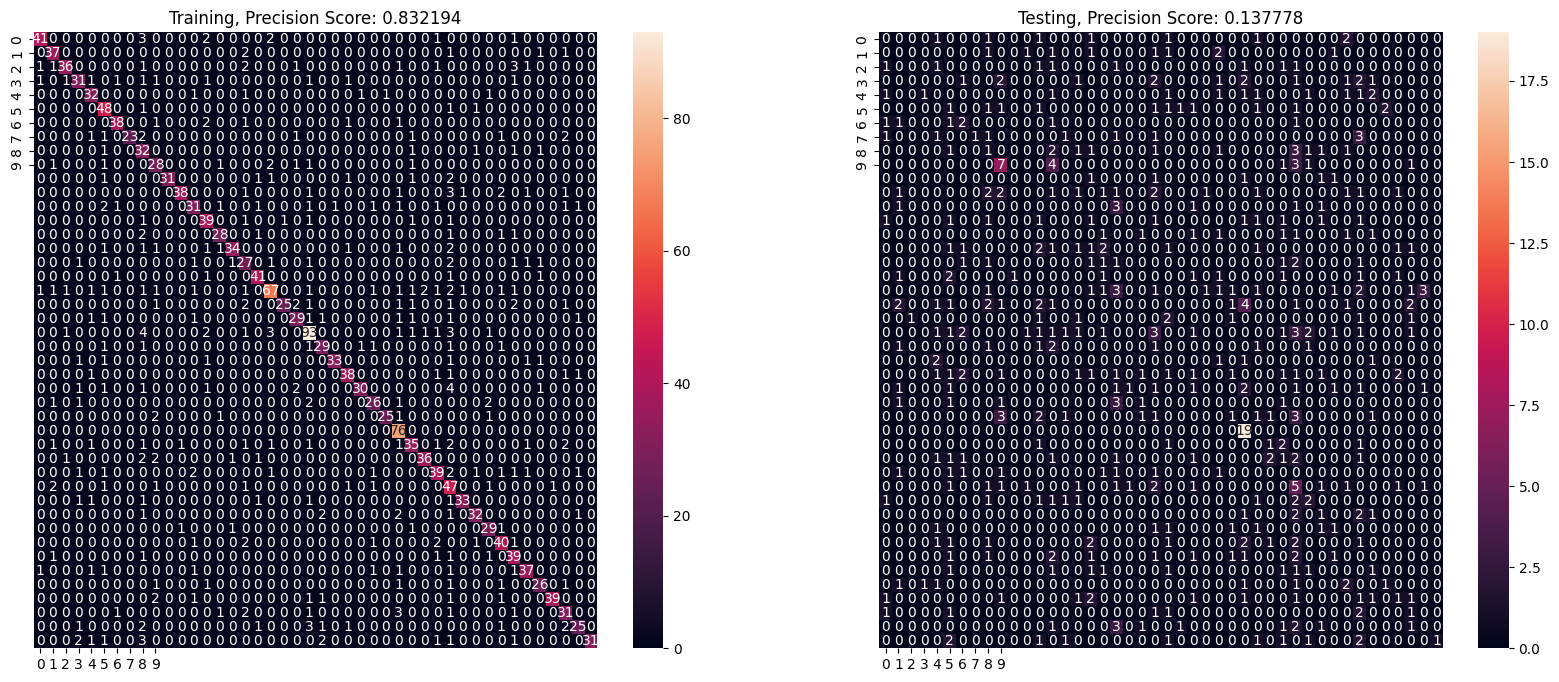

In [365]:
eval_model(model, seen_train_X, species_labelled_train_Y, seen_test_Y, species_labelled_test_Y)